In [1]:
%cd ..

/home/teo/userdata/git_libraries/SejongMusic


In [2]:
with open('music_score/yeominlak_in_text/yemoinlak_omr.txt') as f:
    omr = f.read()


In [6]:
[len(x.split('\n')) for x in omr.split('\n\n')]

[224, 224, 224, 224, 224, 224]

In [104]:
%cd '/home/danbi/userdata/DANBI/gugakwon/Yeominrak'
%load_ext autoreload
%autoreload 2

from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch
from collections import defaultdict, Counter
import copy
import numpy as np

from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore, Tokenizer, Part
from model import Seq2seq, Converter, AttentionSeq2seq, QkvAttnSeq2seq
import random as random
from loss import nll_loss
from trainer import Trainer
from decode import MidiDecoder
from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence, pack_padded_sequence
import torch
from torch.utils.data import Dataset, DataLoader

/home/danbi/userdata/DANBI/gugakwon/Yeominrak
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class AlignedScore:
  def __init__(self, xml_path='0_edited.musicxml', valid_measure_num = [i for i in range(80, 96)], \
    slice_measure_num = 4, sample_len = 1000, is_valid = False, use_pitch_modification=False) -> None:
        
    self.score = converter.parse(xml_path)
    self.parts = [Part(part, i) for i, part in enumerate(self.score.parts)]
    self.offset_list = [part_list.measure_duration for part_list in self.parts]
    
    self.measure_offset_vocab = []
    self.measure_features = [self.get_feature(i) for i in range(len(self.parts))]
    
    self.tokenizer = Tokenizer(self.parts)
    self.vocab = self.tokenizer.vocab
    self.vocab_size_dict = self.tokenizer.vocab_size_dict
    
    self.is_valid = is_valid
    self.use_pitch_modification = use_pitch_modification
    
    if is_valid:
      self.valid_measure_num = valid_measure_num
    else:
      self.valid_measure_num = [i for i in range(len(self.measure_features[0])) if i not in valid_measure_num] # 남은 trainset 마디 개수!
    
    self.slice_info = self.update_slice_info()
    valid_list = [0,1,2,3,5,6,7]
    self.result_pairs = [(a, b) for i, a in enumerate(valid_list[:-2]) for b in valid_list[i+2:]]
    
  def get_feature(self, part_idx):
    # (index, pitch, duration, offset, dynamic), 
    part = self.parts[part_idx]
    measure_set = []
    for measure_idx, measure in enumerate(part.measures):
        each_measure = []
        for note in measure:
            # note_measure_offset, dynamic = self.get_offset_and_dynamics(note, part_idx, measure_idx) 
            each_measure.append([part_idx, note.pitch, note.duration, note.measure_offset, note.dynamic])
        # if len(each_measure) > 0:
        measure_set.append(each_measure)
    return measure_set  
  
  def update_slice_info(self):
    numbers = self.valid_measure_num
    split_num_list = []
    while numbers:
      if self.is_valid: 
        random_measure_num = 2
      else:
        random_measure_num = random.randint(2, 4)
      split_num_list.append(numbers[:random_measure_num])
      numbers = numbers[random_measure_num:]
    return split_num_list
  
  def __len__(self):
    if self.is_valid:
      valid_list = [0,1,2,3,5,6,7]
      result_pairs = [(a, b) for i, a in enumerate(valid_list[:-2]) for b in valid_list[i+2:]]
      return len(result_pairs)
    return len(self.slice_info) * 5
  
  def modify_pitch(self, target_list):
    ratio = 0.3
    modified_list = []
    for note in target_list[1:-1]:
      if random.random() < ratio:
        pitch = random.choice(self.vocab['pitch'][3:])
      else:
        pitch = note[1]
      # new_note = [note[0], pitch, note[2], note[3], note[4], [note[5]]]
      new_note = [note[0], pitch, note[2], note[3], note[4]]
      modified_list.append(new_note)
    completed_list = [target_list[0]] + modified_list + [target_list[-1]]
    return completed_list  

  def get_processed_feature(self, front_part_idx, back_part_idx, segment_idx):
    source_start_token = [front_part_idx, 'start', 'start', 'start', 'start']
    source_end_token = [front_part_idx, 'end', 'end', 'end', 'end']
    target_start_token = [back_part_idx, 'start', 'start', 'start', 'start']
    target_end_token = [back_part_idx, 'end', 'end', 'end', 'end']
    
    measure_list = self.slice_info[segment_idx]
    original_source_list = []
    original_target_list = []
    for i in measure_list:
      for item in self.measure_features[front_part_idx][i]:
          if isinstance(item, list):
              original_source_list.append(item)

      for item in self.measure_features[back_part_idx][i]:
          if isinstance(item, list):
              original_target_list.append(item)

    # 여기서 measure_diff 및 measure_idx를 집어넣자!
    
    source_list = [source_start_token] + original_source_list + [source_end_token]
    target_list = [target_start_token] + original_target_list
    if self.use_pitch_modification and not self.is_valid:
        target_list = self.modify_pitch(target_list)
    shifted_target_list = original_target_list + [target_end_token]
    # print(target_list, shifted_target_list)
    source = [self.tokenizer(note_feature) for note_feature in source_list]
    target = [self.tokenizer(note_feature) for note_feature in target_list]
    shifted_target = [self.tokenizer(note_feature) for note_feature in shifted_target_list]
    
    return torch.LongTensor(source), torch.LongTensor(target), torch.LongTensor(shifted_target)
    
  def __getitem__(self, idx):
    if self.is_valid:
      front_part_idx, back_part_idx = self.result_pairs[idx]
      src, tgt, shifted_tgt = self.get_processed_feature(front_part_idx, back_part_idx, idx)
      return src, tgt, shifted_tgt
    
    sample_success = False
    while not sample_success:
      front_part_idx = random.choice(range(len(self.parts)-1))
      # back_part_idx should be bigger than front_part_idx
      back_part_idx = random.randint(front_part_idx + 1, min(len(self.parts) - 1, front_part_idx + 2))
      src, tgt, shifted_tgt = self.get_processed_feature(front_part_idx, back_part_idx, idx)          
      if len(src) > 2 and len(tgt) > 1:
        sample_success = True
    return src, tgt, shifted_tgt    

In [106]:
train_dataset = AlignedScore(is_valid= False)
val_dataset = AlignedScore(is_valid= True)
len(train_dataset), len(val_dataset)  

(230, 15)

In [96]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pack_collate)


(245, 15)

In [101]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pack_collate)
decoder = MidiDecoder(train_dataset.tokenizer, train_loader)

In [3]:
print(set([note.pitch for i in range(8) for note in score_set.parts[i].tie_cleaned_notes]))
print(set([note.duration for i in range(8) for note in score_set.parts[i].tie_cleaned_notes]))
print(len(set([note.duration for i in range(8) for note in score_set.parts[i].tie_cleaned_notes])))
print(len([note.duration for i in range(8) for note in score_set.parts[i].tie_cleaned_notes]))

{34.0, 39.0, 41.0, 44.0, 46.0, 48.0, 49.0, 51.0, 53.0, 55.0, 56.0, 58.0, 60.0, 63.0}
{0.5, 1.5, 2.5, 1.0, 4.0, 5.0, 3.0, 2.0, 8.0, 1.6666666666666665, Fraction(2, 3), Fraction(1, 3)}
12
6809


In [4]:
contours = [part.make_pitch_contour() for part in score_set.parts]

160
160
160
160
65
115
160
160


In [29]:
score_set.parts[0].measures
for note in self.parts[part_idx].measures[idx]:
  note_measure_offset = note.offset - self.parts[part_idx].measure_offsets[idx]

[[Gnote: 51.0, 8.0, 0.0],
 [],
 [Gnote: 48.0, 4.0, 8.0],
 [Gnote: 46.0, 2.5, 12.0, Gnote: 48.0, 1.5, 14.5],
 [Gnote: 53.0, 8.0, 16.0],
 [],
 [Gnote: 53.0, 8.0, 24.0],
 [],
 [Gnote: 51.0, 8.0, 32.0],
 [],
 [Gnote: 53.0, 4.0, 40.0],
 [Gnote: 53.0, 2.5, 44.0, Gnote: 51.0, 1.5, 46.5],
 [Gnote: 48.0, 4.0, 48.0],
 [Gnote: 46.0, 2.5, 52.0, Gnote: 44.0, 1.5, 54.5],
 [Gnote: 46.0, 4.0, 56.0],
 [Gnote: 48.0, 2.5, 60.0, Gnote: 46.0, 1.5, 62.5],
 [Gnote: 44.0, 4.0, 64.0],
 [Gnote: 44.0, 2.5, 68.0, Gnote: 46.0, 1.0, 70.5, Gnote: 44.0, 0.5, 71.5],
 [Gnote: 41.0, 4.0, 72.0],
 [Gnote: 39.0, 2.5, 76.0, Gnote: 41.0, 1.5, 78.5],
 [Gnote: 44.0, 2.5, 80.0, Gnote: 46.0, 1.5, 82.5],
 [Gnote: 48.0, 4.0, 84.0],
 [Gnote: 48.0, 8.0, 88.0],
 [],
 [Gnote: 46.0, 8.0, 96.0],
 [],
 [Gnote: 44.0, 4.0, 104.0],
 [Gnote: 44.0, 4.0, 108.0],
 [Gnote: 41.0, 4.0, 112.0],
 [Gnote: 44.0, 2.5, 116.0, Gnote: 41.0, 1.5, 118.5],
 [Gnote: 39.0, 8.0, 120.0],
 [],
 [Gnote: 51.0, 8.0, 128.0],
 [],
 [Gnote: 53.0, 8.0, 136.0],
 [],
 [Gn

## Get self-similarity

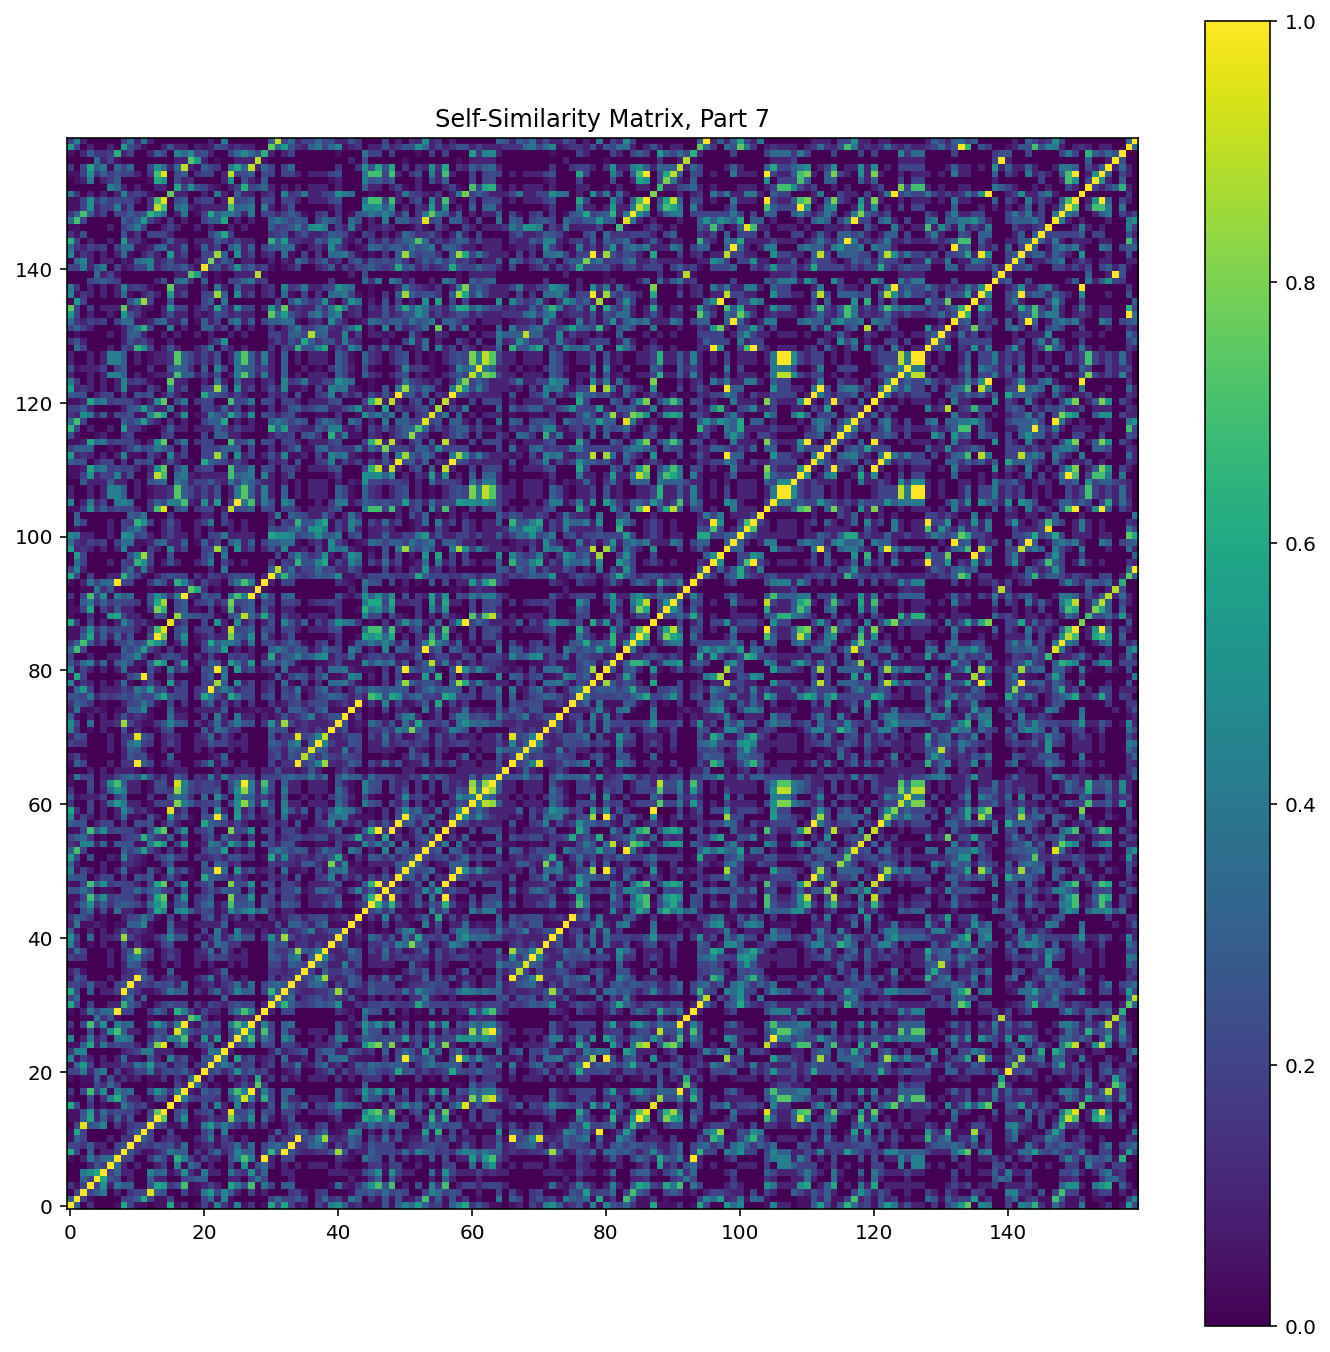

In [26]:
import matplotlib.pyplot as plt
import numpy as np

part_idx = 7
measure_sample = 120
measure_by_contour = [contours[part_idx][i * measure_sample : (i + 1) * measure_sample] for i in range(160)]

self_similarity_matrix = np.zeros((160, 160))

for i, measure1 in enumerate(measure_by_contour):
    for j, measure2 in enumerate(measure_by_contour):
        similarity = np.sum(measure1 == measure2) / measure_sample  # Calculate similarity
        self_similarity_matrix[i, j] = similarity

plt.figure(figsize=(12, 12))
plt.imshow(self_similarity_matrix, cmap='viridis', origin='lower')
plt.colorbar()
plt.title(f'Self-Similarity Matrix, Part {part_idx}')
plt.show()


## Pitch Contour graph

In [ ]:
import matplotlib.pyplot as plt

measure_start = 80
measure_end = 100

sampling_rate = 12

start_idx = measure_start * 10 * sampling_rate
end_idx = measure_end * 10 * sampling_rate

plt.figure(figsize = (50, 10))
for contour in contours:
  plt.plot(contour[start_idx:end_idx])


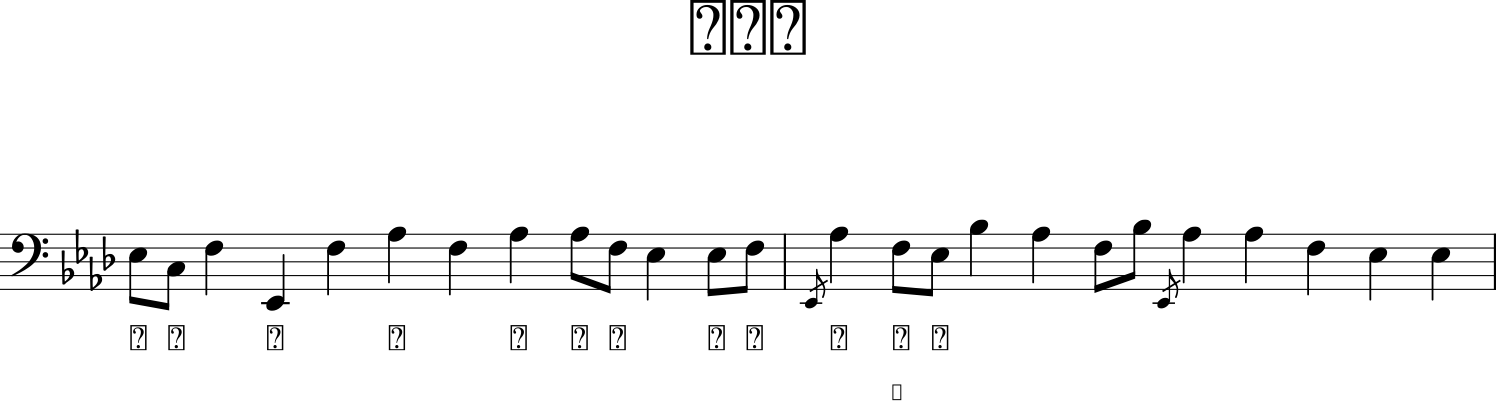

In [58]:
score_set.score.parts[6].measures(11,13).show()